# <center> 3. Dimension Reduction </center>

- PCA
- UMAP
- Clustering of reduced datasets

In [1]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from collections import Counter
%matplotlib inline

In [2]:
##### Jupyter notebook theme setup:
# !pip install jupyterthemes
!jt -t gruvboxd -fs 95 -tfs 11 -nfs 115 -cellw 80% -T
##### Reset theme:
# !jt -r
##### Plot style:
from jupyterthemes import jtplot
jtplot.style()

# Reload page after cell evaluation

In [3]:
def show_cluster_samples(df, labels, n_samples=10):
    """
    Funstion shows random sample of n_samples elements of df from each cluster.
    Imput
    df: pandas.DataFrame: dataset
    labels: numpy.array: list with cluster labels
    n_samples: int: size of each sample
    """
    labels_unique = np.unique(labels)
    fig = plt.figure(figsize=(1.5*n_samples, 1.3*len(labels_unique)))
    img_num = 1
    for label in labels_unique:
        cluster_elements_idx = np.where(labels == label)[0]
        cluster_elements_idx = np.random.choice(cluster_elements_idx, size=n_samples)

        for i, item_idx in enumerate(cluster_elements_idx):
            ax = fig.add_subplot(len(labels_unique), n_samples, img_num)
            ax.set_axis_off()
            ax.imshow(df.loc[item_idx].values.reshape(28, 28), cmap='gray')    
            img_num += 1

# Data import

NB! Dataset isn't presented on github, because it is too large for it (~100 mb)

In [31]:
df = pd.read_csv('data/fashion.csv')
df = df.dropna()

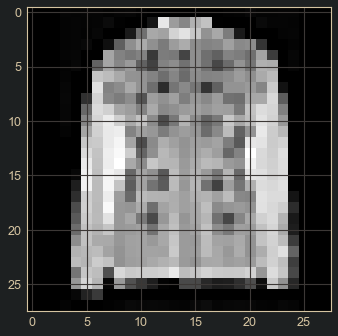

In [5]:
# sample example
plt.imshow(df.loc[5].values.reshape(28, 28), cmap='gray');

# Понижение размерности

## PCA

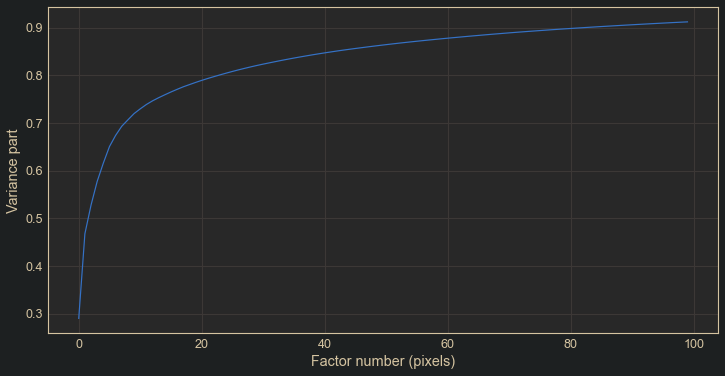

In [6]:
max_comp = 100
pca_tmp = PCA(n_components=max_comp)
pca_tmp.fit(df)
variance = pca_tmp.explained_variance_ratio_
var = [sum(pca_tmp.explained_variance_ratio_[:x]) for x in range(1, max_comp + 1)]
plt.figure(figsize=(12, 6))
plt.ylabel('Variance part')
plt.xlabel('Factor number (pixels)')
plt.plot(var)
plt.show()

In [7]:
# 20-40 seems nice

pca_components_n = 30

In [8]:
pca_model = PCA(n_components=pca_components_n)
pca_model.fit(df.values)
X_pca = pca_model.transform(df.values)

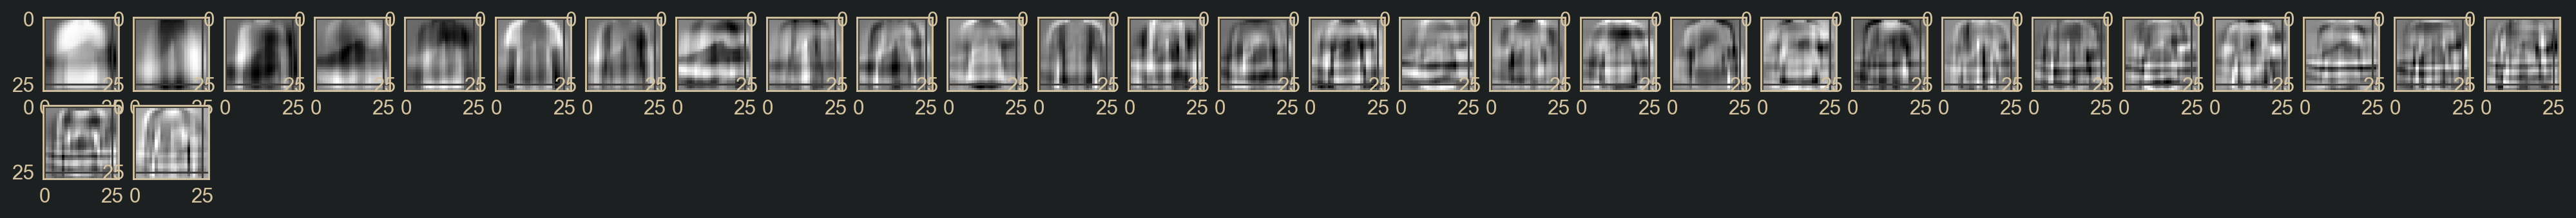

In [9]:
# Principal components visualisation
imsize = 28

fig = plt.figure(figsize=(imsize, imsize), dpi=180)
for i in range(1, pca_components_n + 1):
    img = pca_model.components_[i - 1].reshape(28, 28)
    fig.add_subplot(imsize, imsize, i)
    plt.imshow(img, cmap='gray', aspect='auto')
plt.show()


### UMAP

In [10]:
fit = umap.UMAP(
    n_neighbors=50
    , n_components=25
    , low_memory=True
)
X_umap = fit.fit_transform(df.values);

# Clustering

### PCA + K-means

#### Parameters

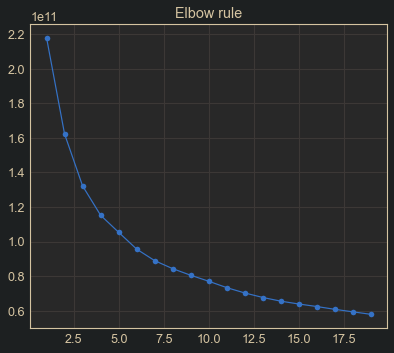

In [20]:
# Elbow rule
model_score = pd.Series(np.nan, index=range(1, 20))
for K in model_score.index:
    model = KMeans(n_clusters=K)
    model.fit(X_pca)
    model_score[K] = model.inertia_
    
model_score.plot(title='Elbow rule', marker='o');

In [13]:
# 9 seems nice
pca_kmeans_cluster_number = 9

#### Model

In [14]:
pca_k_means_model = KMeans(n_clusters=pca_kmeans_cluster_number,
                           init='k-means++',
                           n_init=10,
                           max_iter=300,
                           tol=0.0001,
                           random_state=42,
                           algorithm='auto')
pca_k_means_model.fit(X_pca);

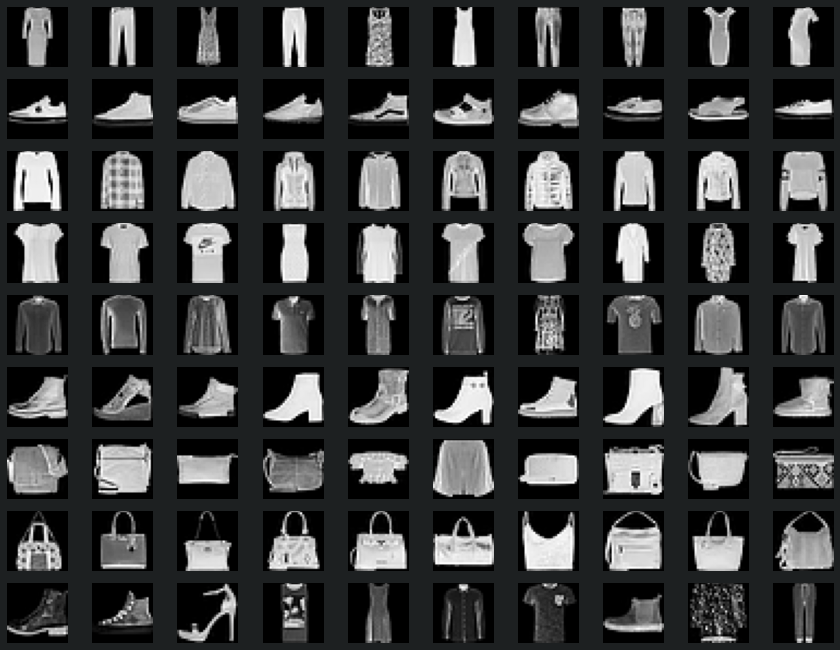

In [15]:
show_cluster_samples(df, pca_k_means_model.labels_, n_samples=10)

By random sample of each cluster we can see pretty accurate split of cloth type by clusters.

### PCA + DBSCAN

#### Model

In [16]:
pca_dbscan_model = DBSCAN(eps=1000, min_samples=40, metric='euclidean')
pca_dbscan_model.fit(X_pca)

DBSCAN(eps=1000, min_samples=40)

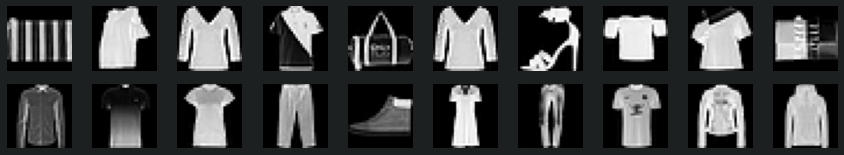

In [17]:
# Отображаем несколько случайных элементов каждого кластера
show_cluster_samples(df, pca_dbscan_model.labels_, n_samples=10)

In [18]:
pca_dbscan_model.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Search of good parameters was unsuccessful.

### UMAP + K-means

#### Parameters

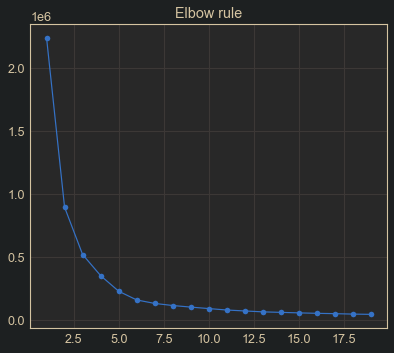

In [21]:
# Elbow rule
model_score = pd.Series(np.nan, index=range(1, 20))
for K in model_score.index:
    model = KMeans(n_clusters=K)
    model.fit(X_umap)
    model_score[K] = model.inertia_
    
model_score.plot(title='Elbow rule', marker='o');

In [22]:
# Looks like 8 or 9
umap_kmeans_cluster_number = 9

#### Model

In [23]:
umap_k_means_model = KMeans(n_clusters=umap_kmeans_cluster_number,
                           init='k-means++',
                           n_init=3,
                           max_iter=300,
                           tol=0.0001,
                           random_state=42,
                           algorithm='auto')
umap_k_means_model.fit(X_umap);

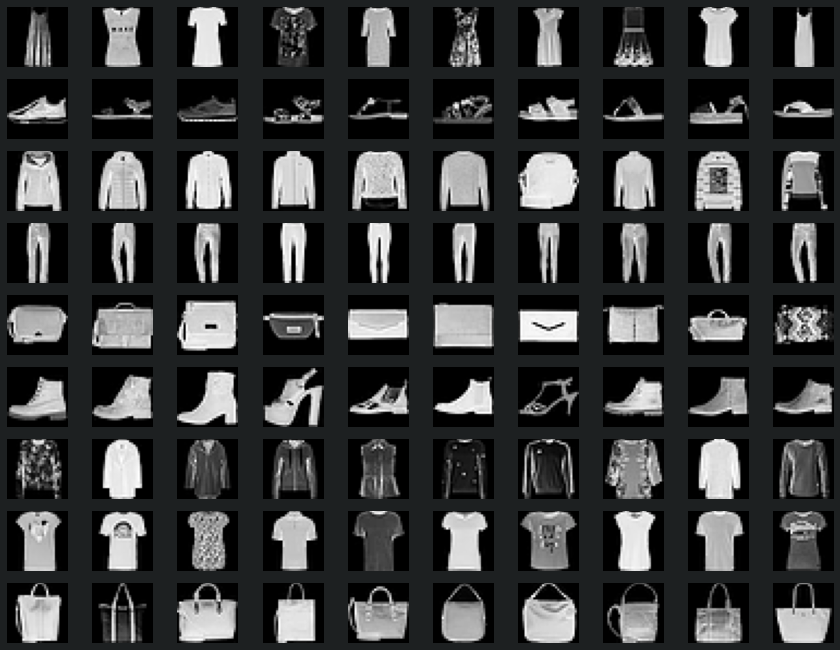

In [24]:
show_cluster_samples(df, umap_k_means_model.labels_, n_samples=10)

Seems better that PCA version.

### UMAP + DBSCAN

#### Model

In [25]:
umap_dbscan_model = DBSCAN(eps=0.35, min_samples=5, metric='euclidean')
umap_dbscan_model.fit(X_umap)

DBSCAN(eps=0.35)

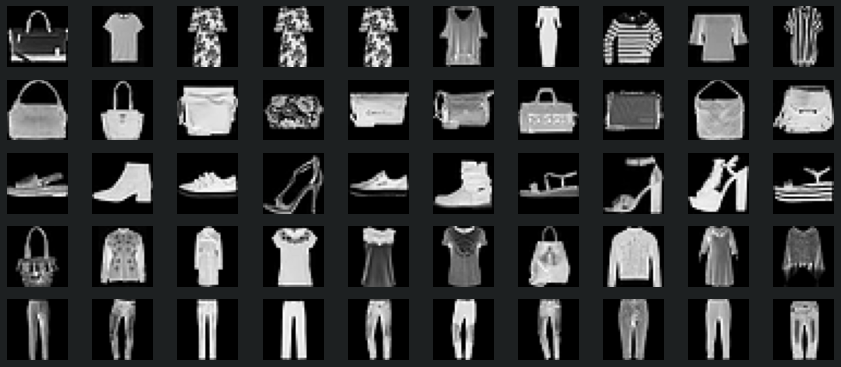

In [26]:
show_cluster_samples(df, umap_dbscan_model.labels_, n_samples=10)

Not so good.

# Result

Lets take UMAP k-means and try to get some results.

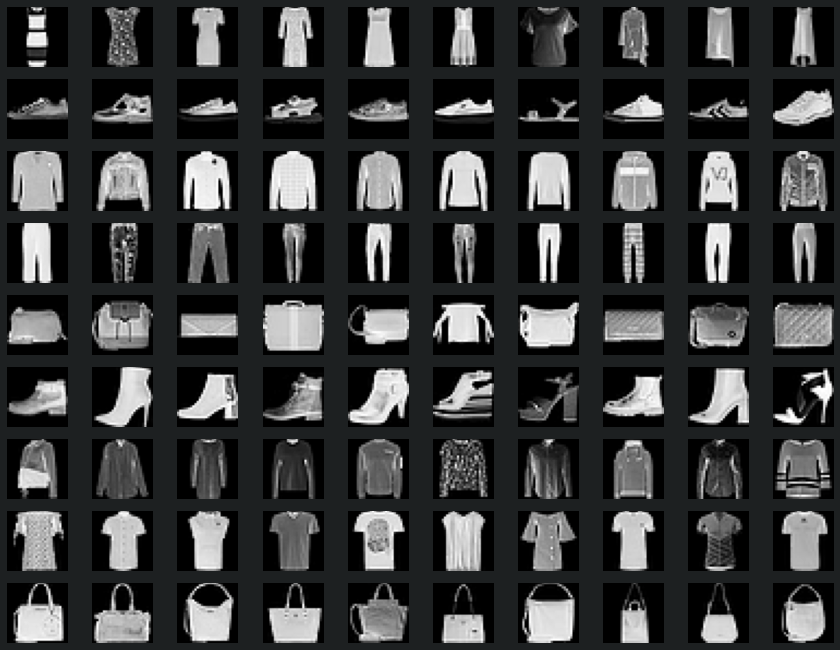

In [27]:
show_cluster_samples(df, umap_k_means_model.labels_, n_samples=10)

По нему руками придумаем названия одежды, соответствующие каждому кластеру

In [28]:
clothes = {
    0: "light clothes",
    1: "boots 1",
    2: "trousers",
    3: "jackets and hoodies",
    4: "handbags",
    5: "women's outerwear",
    6: "women's shoes",
    7: "dresses",
    8: "clutches?"
}

In [30]:
pd.DataFrame({clothes[k]: [v, v / 60_000] for k, v in dict(Counter(umap_k_means_model.labels_)).items()},
            index=["#", "Share"]).transpose()

,#,Share
handbags,2869.0,0.047817
women's outerwear,8571.0,0.142850
trousers,10228.0,0.170467
dresses,5482.0,0.091367
light clothes,8759.0,0.145983
women's shoes,6238.0,0.103967
boots 1,9425.0,0.157083
clutches?,2778.0,0.046300
jackets and hoodies,5650.0,0.094167
